In [1]:
import sys
print(sys.executable)

/Users/liuf9/opt/anaconda3/envs/spac-3913/bin/python


## SPAC Analysis on Lymph Node Tissue Dataset

**Date: 03-2025**

### Module Imports & Utilty Functions, Define I/O

In [2]:
# Import functions from the updated SPAC package
from spac.data_utils import load_csv_files, select_values, combine_dfs, ingest_cells  
from spac.transformations import arcsinh_transformation, z_score_normalization, run_umap, phenograph_clustering, rename_annotations
from spac.visualization import boxplot, histogram, hierarchical_heatmap, dimensionality_reduction_plot, relational_heatmap, sankey_plot, spatial_plot, interactive_spatial_plot, visualize_nearest_neighbor, plot_ripley_l
from spac.spatial_analysis import spatial_interaction, calculate_nearest_neighbor, ripley_l
from spac.phenotyping import assign_manual_phenotypes
from functools import partial

/Users/liuf9/opt/anaconda3/envs/spac-3913/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pickle
import numpy as np
import pandas as pd
from math import ceil, sqrt
import matplotlib.pyplot as plt
import seaborn as sns  
import copy
import anndata
import scanpy as sc
import plotly.io as pio
from PIL import Image
from pprint import pprint
%matplotlib inline

In [4]:
# Setup working dir
data_csv = "example_lymphnode_data.csv"   
output_data_pickle = "Lymph_Node_Tissue.pickle"

In [5]:
# Utility: Save processed AnnData using pickle
def save_pickle(data, filename=output_data_pickle):
    with open(filename, "wb") as f:
        pickle.dump(data, f)
    print(f"Saved processed object to {filename}")

In [6]:
# Utility: Generate a grid frame for multiple subplots with an optional n_plots parameter
def generate_grid_frame(adata, fig_width=12, fig_height=12, dpi=300, n_plots=None):
    # Use n_plots if provided; otherwise, use the total number of annotations
    if n_plots is None:
        n_annotations = len(adata.obs.columns.tolist())
    else:
        n_annotations = n_plots

    # Calculate the number of rows and columns needed
    n_cols = ceil(sqrt(n_annotations))
    n_rows = ceil(n_annotations / n_cols)
    
    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(
        nrows=n_rows, 
        ncols=n_cols, 
        figsize=(fig_width, fig_height), 
        dpi=dpi
        )
    axes = axes.flatten()  # Flatten for easy indexing
    return fig, axes

In [7]:
# Data Loading & Preprocessing
file_names = [data_csv]
data = load_csv_files(file_names)
print("Loaded data:")
print(data.info())


2025-04-14 23:38:05,588 - INFO - CSVs are converted into dataframes and combined into a list!
2025-04-14 23:38:05,589 - INFO - Total of 1 dataframes in the list.
2025-04-14 23:38:05,589 - INFO - File name: example_lymphnode_data.csv
2025-04-14 23:38:05,590 - INFO - Info: 
2025-04-14 23:38:05,601 - INFO - None
2025-04-14 23:38:05,601 - INFO - Description: 
2025-04-14 23:38:05,671 - INFO -             CellID          DNA1          BG1          BG2          BG3  \
count  4825.000000   4825.000000  4825.000000  4825.000000  4825.000000   
mean   2413.000000  30125.675971   883.482671   562.292221  1102.110284   
std    1393.001855   9488.749806   111.565519   111.174097    51.998103   
min       1.000000   6806.434783   609.449438   373.991071   975.745098   
25%    1207.000000  22830.342340   807.523148   495.817204  1073.873684   
50%    2413.000000  29107.907560   879.502762   540.023256  1096.061350   
75%    3619.000000  36504.000000   945.276498   596.254826  1121.433657   
max    48

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4825 entries, 0 to 4824
Data columns (total 85 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CellID              4825 non-null   int64  
 1   DNA1                4825 non-null   float64
 2   BG1                 4825 non-null   float64
 3   BG2                 4825 non-null   float64
 4   BG3                 4825 non-null   float64
 5   DNA2                4825 non-null   float64
 6   CD25                4825 non-null   float64
 7   CD2                 4825 non-null   float64
 8   CD10                4825 non-null   float64
 9   DNA3                4825 non-null   float64
 10  CD163               4825 non-null   float64
 11  CD3D                4825 non-null   float64
 12  CD5                 4825 non-null   float64
 13  DNA4                4825 non-null   float64
 14  CD30                4825 non-null   float64
 15  ACTIN               4825 non-null   float64
 16  CD45  

In [8]:
# Define the manual phenotype codes and names as a DataFrame
phenotype_definitions = pd.DataFrame([
    {"phenotype_code": "CD3D+CD4+FOXP3+", "phenotype_name": "Regulatory T Cell"},
    {"phenotype_code": "CD3D+CD4+",       "phenotype_name": "Helper T Cell"},
    {"phenotype_code": "CD3D+CD8A+",      "phenotype_name": "Cytotoxic T Cell"},
    {"phenotype_code": "CD3D+",           "phenotype_name": "T Cell"},
    {"phenotype_code": "CD20+",           "phenotype_name": "B Cell"},
    {"phenotype_code": "CD21+CD20-",      "phenotype_name": "Follicular Dendritic Cell"},
    {"phenotype_code": "CD56+",           "phenotype_name": "NK Cell"},
    {"phenotype_code": "CD68+",           "phenotype_name": "CD68+ Macrophage"},
    {"phenotype_code": "CD11C+",          "phenotype_name": "Dendritic Cell"},
    {"phenotype_code": "CD15+",           "phenotype_name": "Granulocyte"},
    {"phenotype_code": "KI67+",           "phenotype_name": "Proliferating Cell"},
    {"phenotype_code": "PD1+",            "phenotype_name": "Activated T/B Cell"},
    {"phenotype_code": "HLADR+",          "phenotype_name": "Activated APC"},
    {"phenotype_code": "CD163+",          "phenotype_name": "CD163+ Macrophage"}
])

# (Optional) Preview the phenotype definitions (trimmed to the top rows)
print("Phenotype definitions (top rows):")
print(phenotype_definitions.head())

# Assign manual phenotypes to each cell (adds a 'manual_phenotype' column to the DataFrame)
assign_manual_phenotypes(data, phenotype_definitions, suffix="_expression")

# Print the top rows of the updated DataFrame
print("Data with manual phenotypes (top rows):")
print(data.head())

# Save the DataFrame with the new 'manual_phenotype' column to a pickle file
save_pickle(data)


Phenotype definitions (top rows):
    phenotype_code     phenotype_name
0  CD3D+CD4+FOXP3+  Regulatory T Cell
1        CD3D+CD4+      Helper T Cell
2       CD3D+CD8A+   Cytotoxic T Cell
3            CD3D+             T Cell
4            CD20+             B Cell

#####################################

Summary of cells that matched each phenotype:
NB: Cells count have matched other phenotypes as well
Regulatory T Cell: 527 cell(s)
Helper T Cell: 1123 cell(s)
Cytotoxic T Cell: 999 cell(s)
T Cell: 2234 cell(s)
B Cell: 922 cell(s)
Follicular Dendritic Cell: 713 cell(s)
NK Cell: 676 cell(s)
CD68+ Macrophage: 701 cell(s)
Dendritic Cell: 2515 cell(s)
Granulocyte: 443 cell(s)
Proliferating Cell: 1130 cell(s)
Activated T/B Cell: 1180 cell(s)
Activated APC: 2533 cell(s)
CD163+ Macrophage: 571 cell(s)

#####################################

Summary of cells that matched multiple phenotypes:
Cells that matched 0 phenotype(s): 252 cells
Cells that matched 1 phenotype(s): 515 cells
Cells that matched

In [9]:
# Ingest the data into an AnnData object for SPAC analysis
feature_names = [
    "CD25", "CD2", "CD10", "CD163", "CD3D", "CD5", "CD30", "ACTIN", "CD45",
    "CD206", "CD68", "PD1", "KI67", "CD11C", "CD7", "CD8A", "FOXP3", "CD20",
    "CD4", "HLADR", "PSTAT3", "PS6", "PERK", "CD21", "CD43", "NOS2", "PDL1",
    "CD11B", "CD57", "MHCI", "CD15", "ASMA", "CD56"
]
regex_str = [f"^{feature}$" for feature in feature_names]
x_col = "X_centroid"
y_col = "Y_centroid"
annotation = ["broad_cell_type", "detailed_cell_type", "manual_phenotype"]

# Create the AnnData object by ingesting the DataFrame
adata = ingest_cells(
    dataframe=data,
    regex_str=regex_str,
    x_col=x_col,
    y_col=y_col,
    annotation=annotation
)

# Print a summary of the AnnData object to verify it was created successfully
print(adata)

# Save the AnnData object to a pickle file for later use
save_pickle(adata, "Lymph_Node_Tissue.pickle")


^CD25$
^CD2$
^CD10$
^CD163$
^CD3D$
^CD5$
^CD30$
^ACTIN$
^CD45$
^CD206$
^CD68$
^PD1$
^KI67$
^CD11C$
^CD7$
^CD8A$
^FOXP3$
^CD20$
^CD4$
^HLADR$
^PSTAT3$
^PS6$
^PERK$
^CD21$
^CD43$
^NOS2$
^PDL1$
^CD11B$
^CD57$
^MHCI$
^CD15$
^ASMA$
^CD56$
AnnData object with n_obs × n_vars = 4825 × 33
    obs: 'broad_cell_type', 'detailed_cell_type', 'manual_phenotype'
    obsm: 'spatial'
Saved processed object to Lymph_Node_Tissue.pickle


/Users/liuf9/opt/anaconda3/envs/spac-3913/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/liuf9/opt/anaconda3/envs/spac-3913/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Visualizing Feature Expression with Boxplot

Calculating Box Plot...
(<Figure size 1000x500 with 1 Axes>, <Axes: title={'center': 'Multiple Features'}, xlabel='Feature', ylabel='log(Intensity)'>,           CD25       CD2      CD10     CD163      CD3D       CD5      CD30  \
0     6.367469  6.428726  7.382608  6.235047  6.170844  7.493546  6.989383   
1     6.340171  6.094227  7.339796  6.210249  6.186009  7.492722  6.963594   
2     6.503502  6.354950  7.473457  6.308190  6.204894  7.550736  7.073453   
3     6.327050  6.015125  7.351632  6.159875  5.852472  7.480882  6.986802   
4     6.333280  6.264265  7.376497  6.180153  5.923984  7.500814  6.949162   
...        ...       ...       ...       ...       ...       ...       ...   
4820  6.508043  6.314653  7.348776  6.348435  6.612809  7.481223  7.093852   
4821  6.465361  6.637015  7.346788  6.298223  7.046816  7.471629  7.046493   
4822  6.558302  6.660794  7.419973  6.319144  6.822848  7.470294  7.091032   
4823  6.337040  6.281594  7.239791  6.260537  6.503732  7.421273  6.9

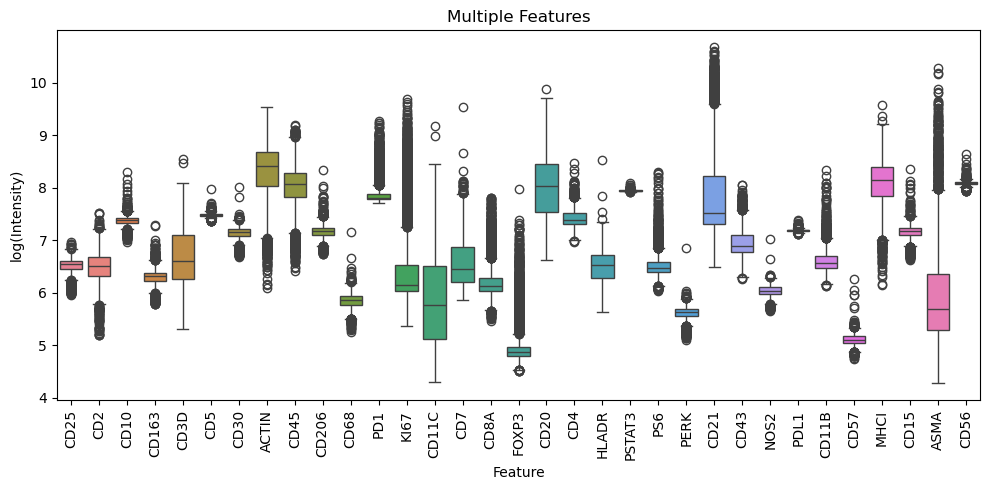

In [10]:
# Define parameters for the boxplot (consistent with NIDAP defaults)
annotation = None
second_annotation = None
layer_to_plot = None  
features_to_plot = adata.var_names.tolist()  # include all features (genes) in the plot

# Plot settings
log_scale = True
showfliers = True

# Create the boxplot for all features and capture the summary statistics table
summary_stats_table = boxplot(
    adata=adata,
    annotation=annotation,
    second_annotation=second_annotation,
    features=features_to_plot,
    layer=layer_to_plot,
    log_scale=log_scale,
    showfliers=showfliers
)

# Display the summary statistics table in the notebook output
print(summary_stats_table)

### Visualizing Data Distribution with Histogram

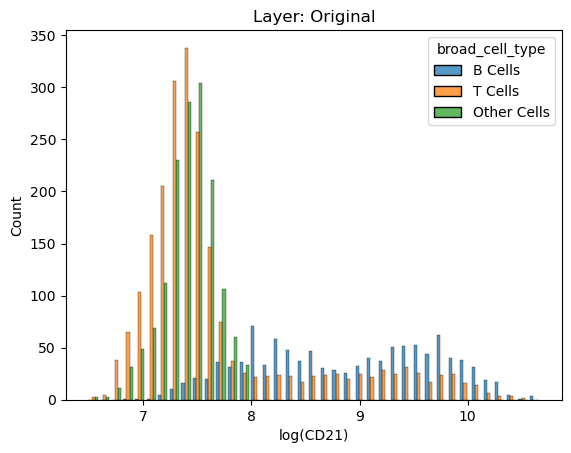

In [11]:
# Create the histogram plot for CD21 expression grouped by broad_cell_type
fig, ax = histogram(
    adata,
    feature="CD21",
    group_by="broad_cell_type",
    layer=None,          
    annotation=None,     
    together=True,       # all groups in one plot (overlayed/dodged)
    x_log_scale=True,    # log-scale X axis (CD21 values)
    y_log_scale=False,   # linear-scale Y axis (counts)
    multiple="dodge",
    shrink=0.8,
    bins="auto",
    alpha=0.75,
    stat="count"
)
# plt.show()  

## Data Transformation

### Arcsinh Transformation

In [12]:
# Normalize the features with arcsinh transformation
norm_output_layer = 'arcsinh_percentile'
arcsinh_transformation(
    adata,
    percentile=10,
    output_layer=norm_output_layer
)
print(f"Transformed data stored in layer: {norm_output_layer}")
dataframe = pd.DataFrame(adata.layers[norm_output_layer])
print(dataframe.describe())
print(adata)
save_pickle(adata)

Transformed data stored in layer: arcsinh_percentile
                0            1            2            3            4   \
count  4825.000000  4825.000000  4825.000000  4825.000000  4825.000000   
mean      0.998491     1.153510     0.946259     0.993466     1.381178   
std       0.087849     0.220481     0.060394     0.098968     0.445698   
min       0.620529     0.372477     0.673539     0.639152     0.443195   
25%       0.944311     1.004977     0.912974     0.931807     1.003419   
50%       1.010656     1.150910     0.944820     0.994227     1.283893   
75%       1.057887     1.299170     0.977490     1.051533     1.722808   
max       1.351105     2.072196     1.727710     1.850659     3.149085   

                5            6            7            8            9   ...  \
count  4825.000000  4825.000000  4825.000000  4825.000000  4825.000000  ...   
mean      0.905535     0.970651     1.537216     1.348258     0.983339  ...   
std       0.022254     0.072681     0.44692

### Z-score Normalization

In [13]:
# Z-score normalize the features following arcsinh transformation 
norm_zscore_output_layer = 'arcsinh_z_scores'
z_score_normalization(
    adata,
    input_layer=norm_output_layer,
    output_layer=norm_zscore_output_layer
)
print(f"Transformed data stored in layer: {norm_zscore_output_layer}")
dataframe = pd.DataFrame(adata.layers[norm_zscore_output_layer])
print(dataframe.describe())
print(adata)
save_pickle(adata)

Z-score normalization completed. Data stored in layer "arcsinh_z_scores".
Transformed data stored in layer: arcsinh_z_scores
                 0             1             2             3             4   \
count  4.825000e+03  4.825000e+03  4.825000e+03  4.825000e+03  4.825000e+03   
mean  -7.304232e-16 -5.419269e-16 -3.534306e-17 -5.065838e-16 -1.649343e-16   
std    1.000104e+00  1.000104e+00  1.000104e+00  1.000104e+00  1.000104e+00   
min   -4.302852e+00 -3.542771e+00 -4.516148e+00 -3.580472e+00 -2.104742e+00   
25%   -6.167979e-01 -6.737455e-01 -5.511957e-01 -6.230825e-01 -8.476531e-01   
50%    1.384945e-01 -1.179618e-02 -2.382979e-02  7.693801e-03 -2.182979e-01   
75%    6.761846e-01  6.607149e-01  5.171605e-01  5.867871e-01  7.665848e-01   
max    4.014279e+00  4.167163e+00  1.294053e+01  8.662250e+00  3.967009e+00   

                 5             6             7             8             9   \
count  4.825000e+03  4.825000e+03  4.825000e+03  4.825000e+03  4.825000e+03   
mean 

## Unsupervised Clustering

### Unsupervised Clustering with Phenograph

In [14]:
# Run Phenograph clustering
resolution = 1
K_NN_Value = 60
cluster_annotations = []

annotation_name = f'phenograph_k{K_NN_Value}_{resolution}'
cluster_annotations.append(annotation_name)
phenograph_clustering(
    adata,
    layer=norm_zscore_output_layer,
    features=adata.var.index.to_list(),  # Use all available features
    k=K_NN_Value,
    seed=42,
    output_annotation=annotation_name,
    resolution_parameter=resolution
    )

for annotation_name in cluster_annotations:
    num_clusters = adata.obs[annotation_name].nunique()
    print(f'\nNumber of clusters identified in "{annotation_name}": {num_clusters}')

print(adata)
save_pickle(adata)

2025-04-14 23:38:06,945 - INFO - Using the table:"arcsinh_z_scores"
2025-04-14 23:38:06,946 - INFO - Using features:"['CD25', 'CD2', 'CD10', 'CD163', 'CD3D', 'CD5', 'CD30', 'ACTIN', 'CD45', 'CD206', 'CD68', 'PD1', 'KI67', 'CD11C', 'CD7', 'CD8A', 'FOXP3', 'CD20', 'CD4', 'HLADR', 'PSTAT3', 'PS6', 'PERK', 'CD21', 'CD43', 'NOS2', 'PDL1', 'CD11B', 'CD57', 'MHCI', 'CD15', 'ASMA', 'CD56']"


Finding 60 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.2887089252471924 seconds
Jaccard graph constructed in 6.233572006225586 seconds
Running Leiden optimization
Leiden completed in 0.46156907081604004 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 10.92943000793457 seconds

Number of clusters identified in "phenograph_k60_1": 10
AnnData object with n_obs × n_vars = 4825 × 33
    obs: 'broad_cell_type', 'detailed_cell_type', 'manual_phenotype', 'phenograph_k60_1'
    uns: 'phenograph_features'
    obsm: 'spatial'
    layers: 'arcsinh_percentile', 'arcsinh_z_scores'
Saved processed object to Lymph_Node_Tissue.pickle


### Cluster Renaming

In [15]:
original_column = "phenograph_k60_1"
renamed_column = "renamed_clusters"

mappings = {
    "0":"Myeloid cells",
    "1":"Regulatory T cells",
    "2":"Proliferative B cells",
    "3":"Myeloid cells",
    "4":"B cells", 
    "5":"CD8 T cells",
    "6":"Follicular helper T cells (Tfh)",
    "7":"ASMA+ cells",
    "8":"NK cells",
    "9":"B cells"
}

print("Cluster Name Mapping: \n", mappings)

rename_annotations(
    adata, 
    src_annotation=original_column,
    dest_annotation=renamed_column,
    mappings=mappings)

print("After Renaming Clusters: \n", adata)

print("\n\n\nPhenograph Cluster Count: \n", 
len(adata.obs[renamed_column].unique().tolist()))

print("\n\n\nPhenograph Cluster Names: \n", 
    adata.obs[renamed_column].unique().tolist())


print(adata)
save_pickle(adata)

Cluster Name Mapping: 
 {'0': 'Myeloid cells', '1': 'Regulatory T cells', '2': 'Proliferative B cells', '3': 'Myeloid cells', '4': 'B cells', '5': 'CD8 T cells', '6': 'Follicular helper T cells (Tfh)', '7': 'ASMA+ cells', '8': 'NK cells', '9': 'B cells'}
The data type of the original column 'phenograph_k60_1' is category.
After Renaming Clusters: 
 AnnData object with n_obs × n_vars = 4825 × 33
    obs: 'broad_cell_type', 'detailed_cell_type', 'manual_phenotype', 'phenograph_k60_1', 'renamed_clusters'
    uns: 'phenograph_features'
    obsm: 'spatial'
    layers: 'arcsinh_percentile', 'arcsinh_z_scores'



Phenograph Cluster Count: 
 8



Phenograph Cluster Names: 
 ['Myeloid cells', 'CD8 T cells', 'Proliferative B cells', 'Regulatory T cells', 'B cells', 'NK cells', 'Follicular helper T cells (Tfh)', 'ASMA+ cells']
AnnData object with n_obs × n_vars = 4825 × 33
    obs: 'broad_cell_type', 'detailed_cell_type', 'manual_phenotype', 'phenograph_k60_1', 'renamed_clusters'
    uns: 'phenog

### UMAP Dimentionality Reduction

In [16]:
# Run UMAP Dimention Reduction
n_neighbors = 200
n_components = 2
min_dist = 0.1
metric = 'euclidean'
random_state = 0
transform_seed = 42
layer = norm_zscore_output_layer
run_umap(
    adata=adata,
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    metric=metric,
    random_state=random_state,
    transform_seed=transform_seed,
    layer=layer
)
save_pickle(adata)

2025-04-14 23:38:17,955 - INFO - Using the table:"arcsinh_z_scores"
/Users/liuf9/opt/anaconda3/envs/spac-3913/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved processed object to Lymph_Node_Tissue.pickle


### UMAP Visualization of Annotations

In [17]:
def plot_umap(layer, selected_annotations=None):
    # Visualizations
    # Plot UMAP with cluster annotations

    # Setup plot parameters
    feature = None
    layer = layer
    method = "umap"
    fig_width = 14
    fig_height = 14
    font_size = 12
    fig_dpi = 300    
    legend_location = "best"

    # Determine which annotations to plot
    if selected_annotations is None:
        annotations_to_plot = adata.obs.columns.tolist()
    else:
        annotations_to_plot = [ann for ann in selected_annotations if ann in adata.obs.columns]

    fig, axes = generate_grid_frame(
        adata,
        fig_width=fig_width,
        fig_height=fig_height,
        dpi=fig_dpi,
        n_plots=len(annotations_to_plot)
    )

    # Loop through each selected annotation and create UMAP plots
    for i, annotation in enumerate(annotations_to_plot):
        ax = axes[i]
        
        # Plot the UMAP for the current annotation
        fig, ax = dimensionality_reduction_plot(
            adata=adata,
            method=method,
            annotation=annotation,
            feature=feature,
            layer=layer,
            ax=ax
        )
        
        # Set plot title and other properties
        ax.set_title(f"UMAP - {annotation}", fontsize=font_size)
        ax.legend(loc=legend_location, bbox_to_anchor=(1.01, 1))
        ax.grid(False)

    # Hide any unused subplots (if any)
    for i in range(len(annotations_to_plot), len(axes)):
        fig.delaxes(axes[i])

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

Running visualization using the coordinates: "X_umap"
Cluster: 0, Points: 971
Cluster: 1, Points: 801
Cluster: 2, Points: 652
Cluster: 3, Points: 650
Cluster: 4, Points: 417
Cluster: 5, Points: 332
Cluster: 6, Points: 326
Cluster: 7, Points: 284
Cluster: 8, Points: 266
Cluster: 9, Points: 126
Running visualization using the coordinates: "X_umap"
Cluster: ASMA+ cells, Points: 284
Cluster: B cells, Points: 543
Cluster: CD8 T cells, Points: 332
Cluster: Follicular helper T cells (Tfh), Points: 326
Cluster: Myeloid cells, Points: 1621
Cluster: NK cells, Points: 266
Cluster: Proliferative B cells, Points: 652
Cluster: Regulatory T cells, Points: 801


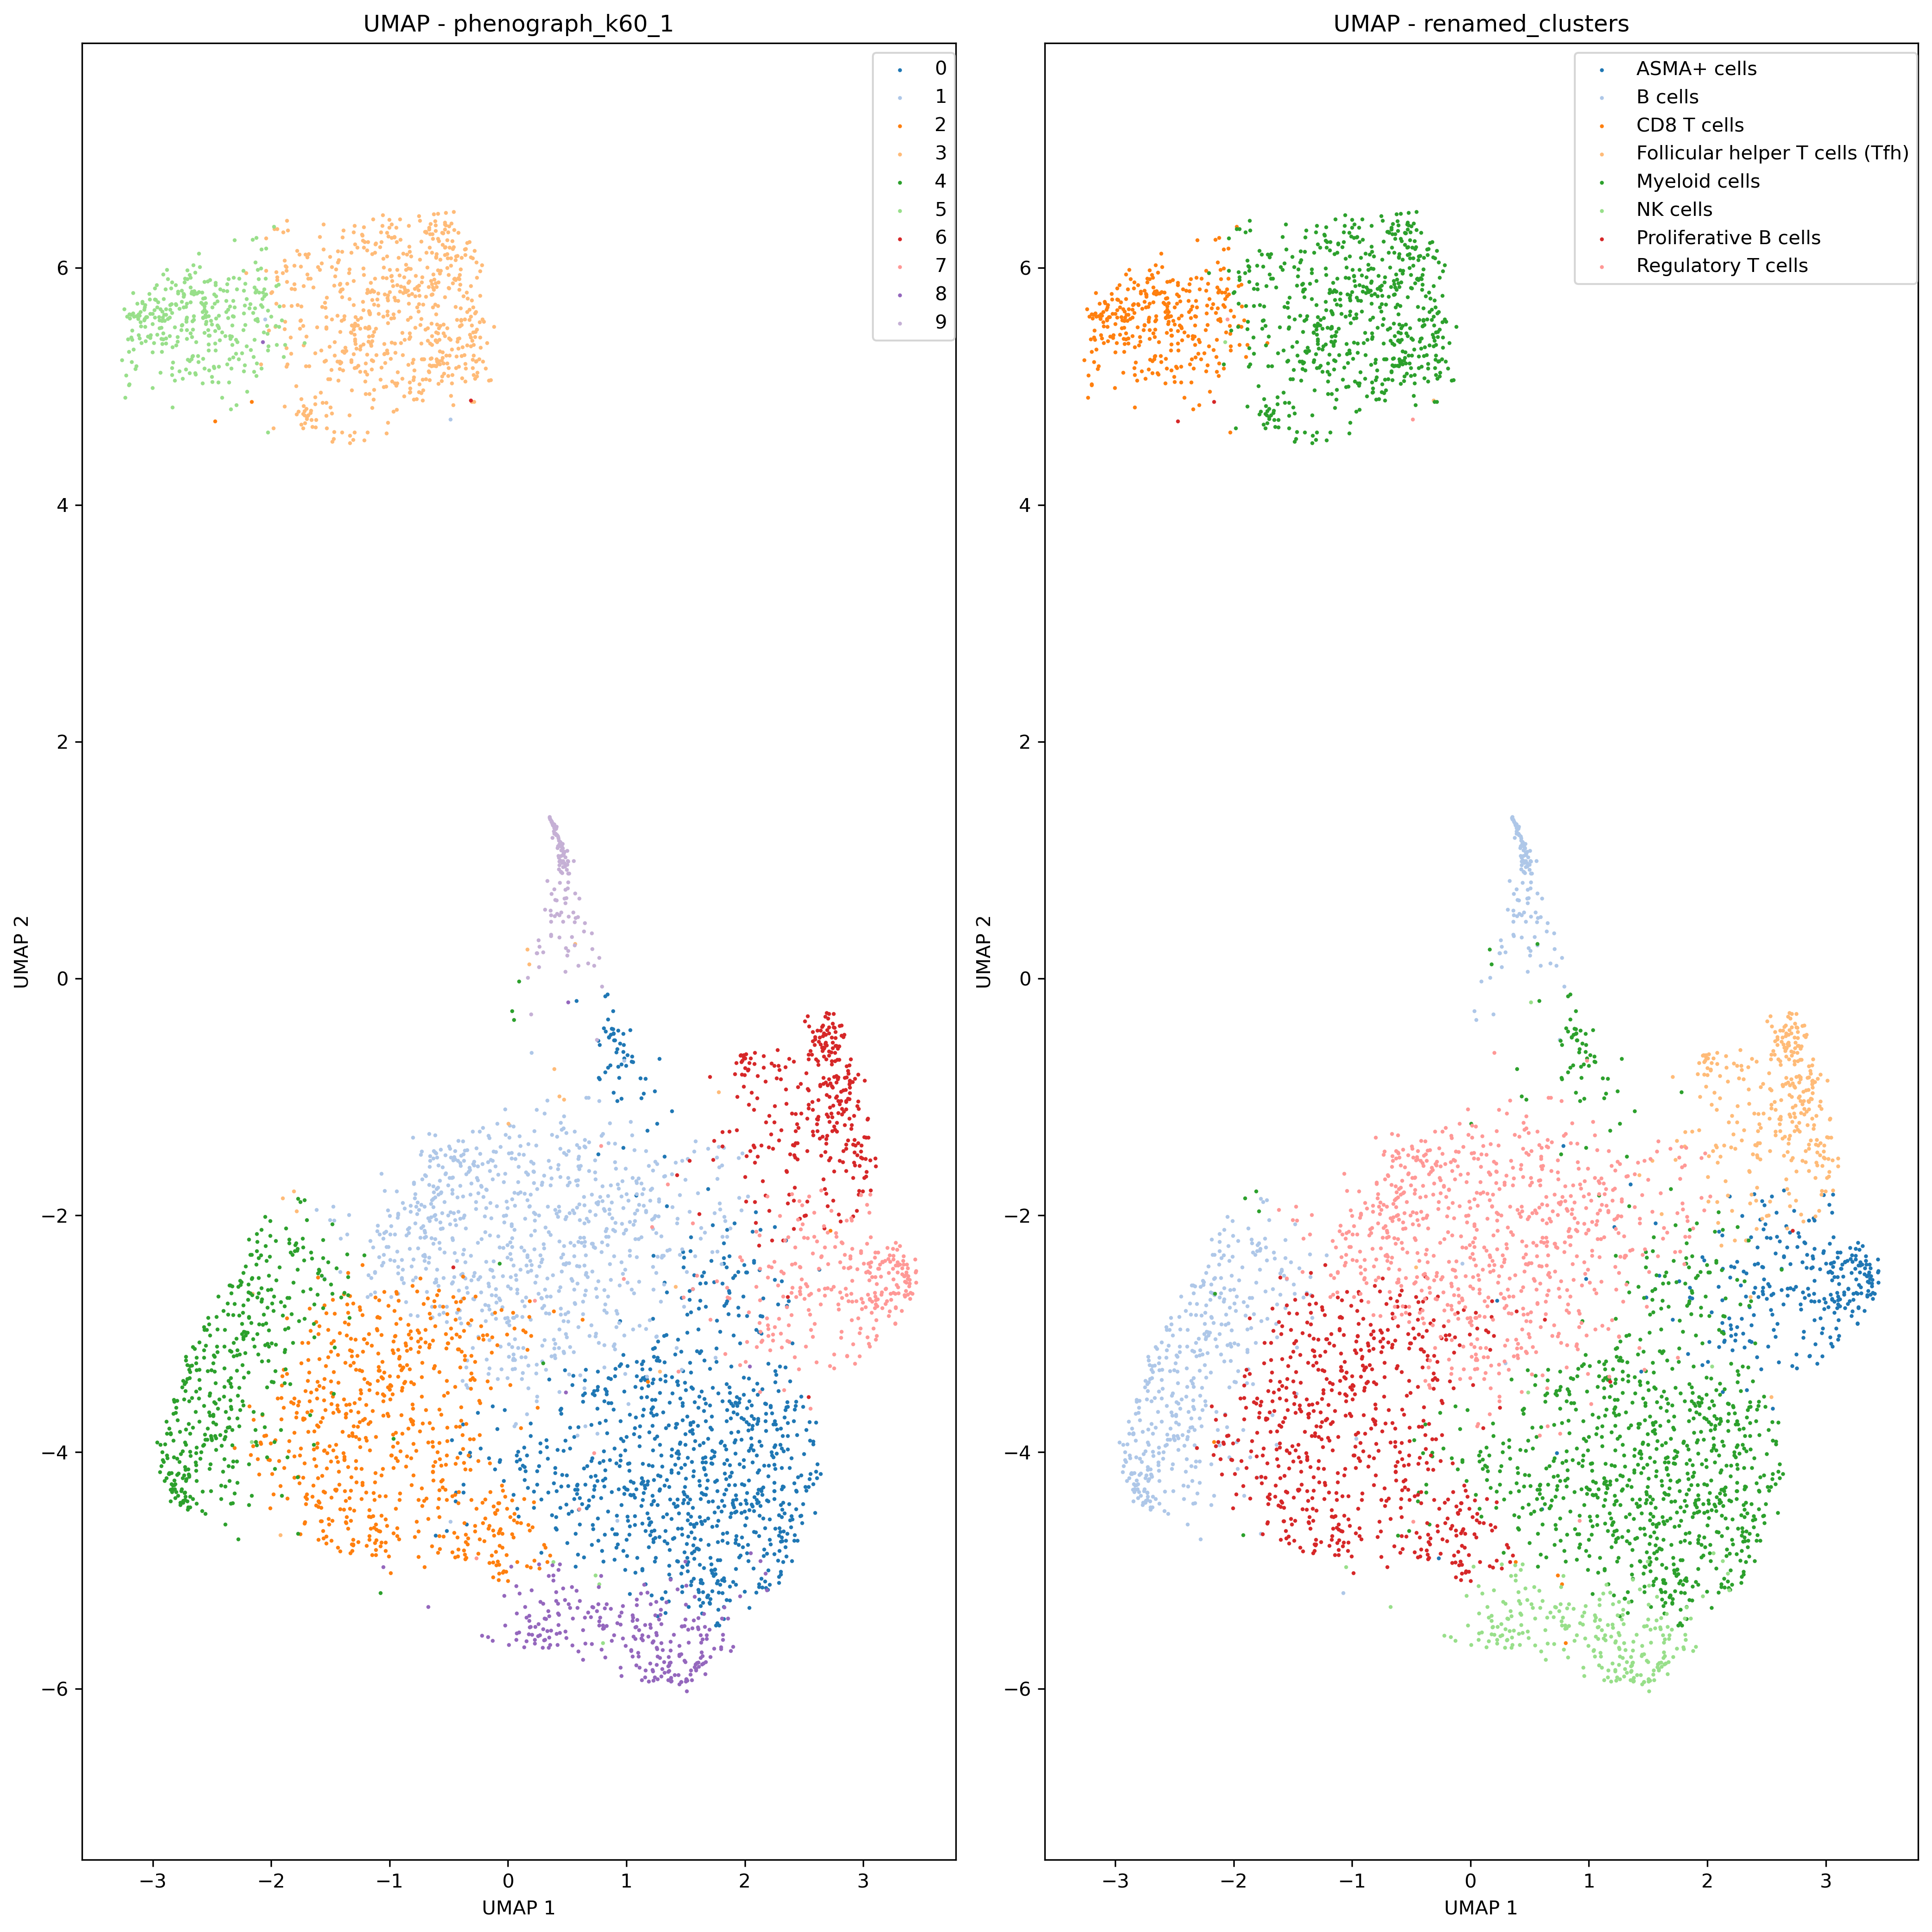

In [18]:
# Plot UMAP with renamed clusters
selected_annotations = ['phenograph_k60_1','renamed_clusters']
plot_umap(norm_zscore_output_layer, selected_annotations)

### Hierachical Heatmaps

/Users/liuf9/Projects/SCSAWorkflow/src/spac/visualization.py:878: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = pd.concat([intensities, labels], axis=1).groupby(annotation)


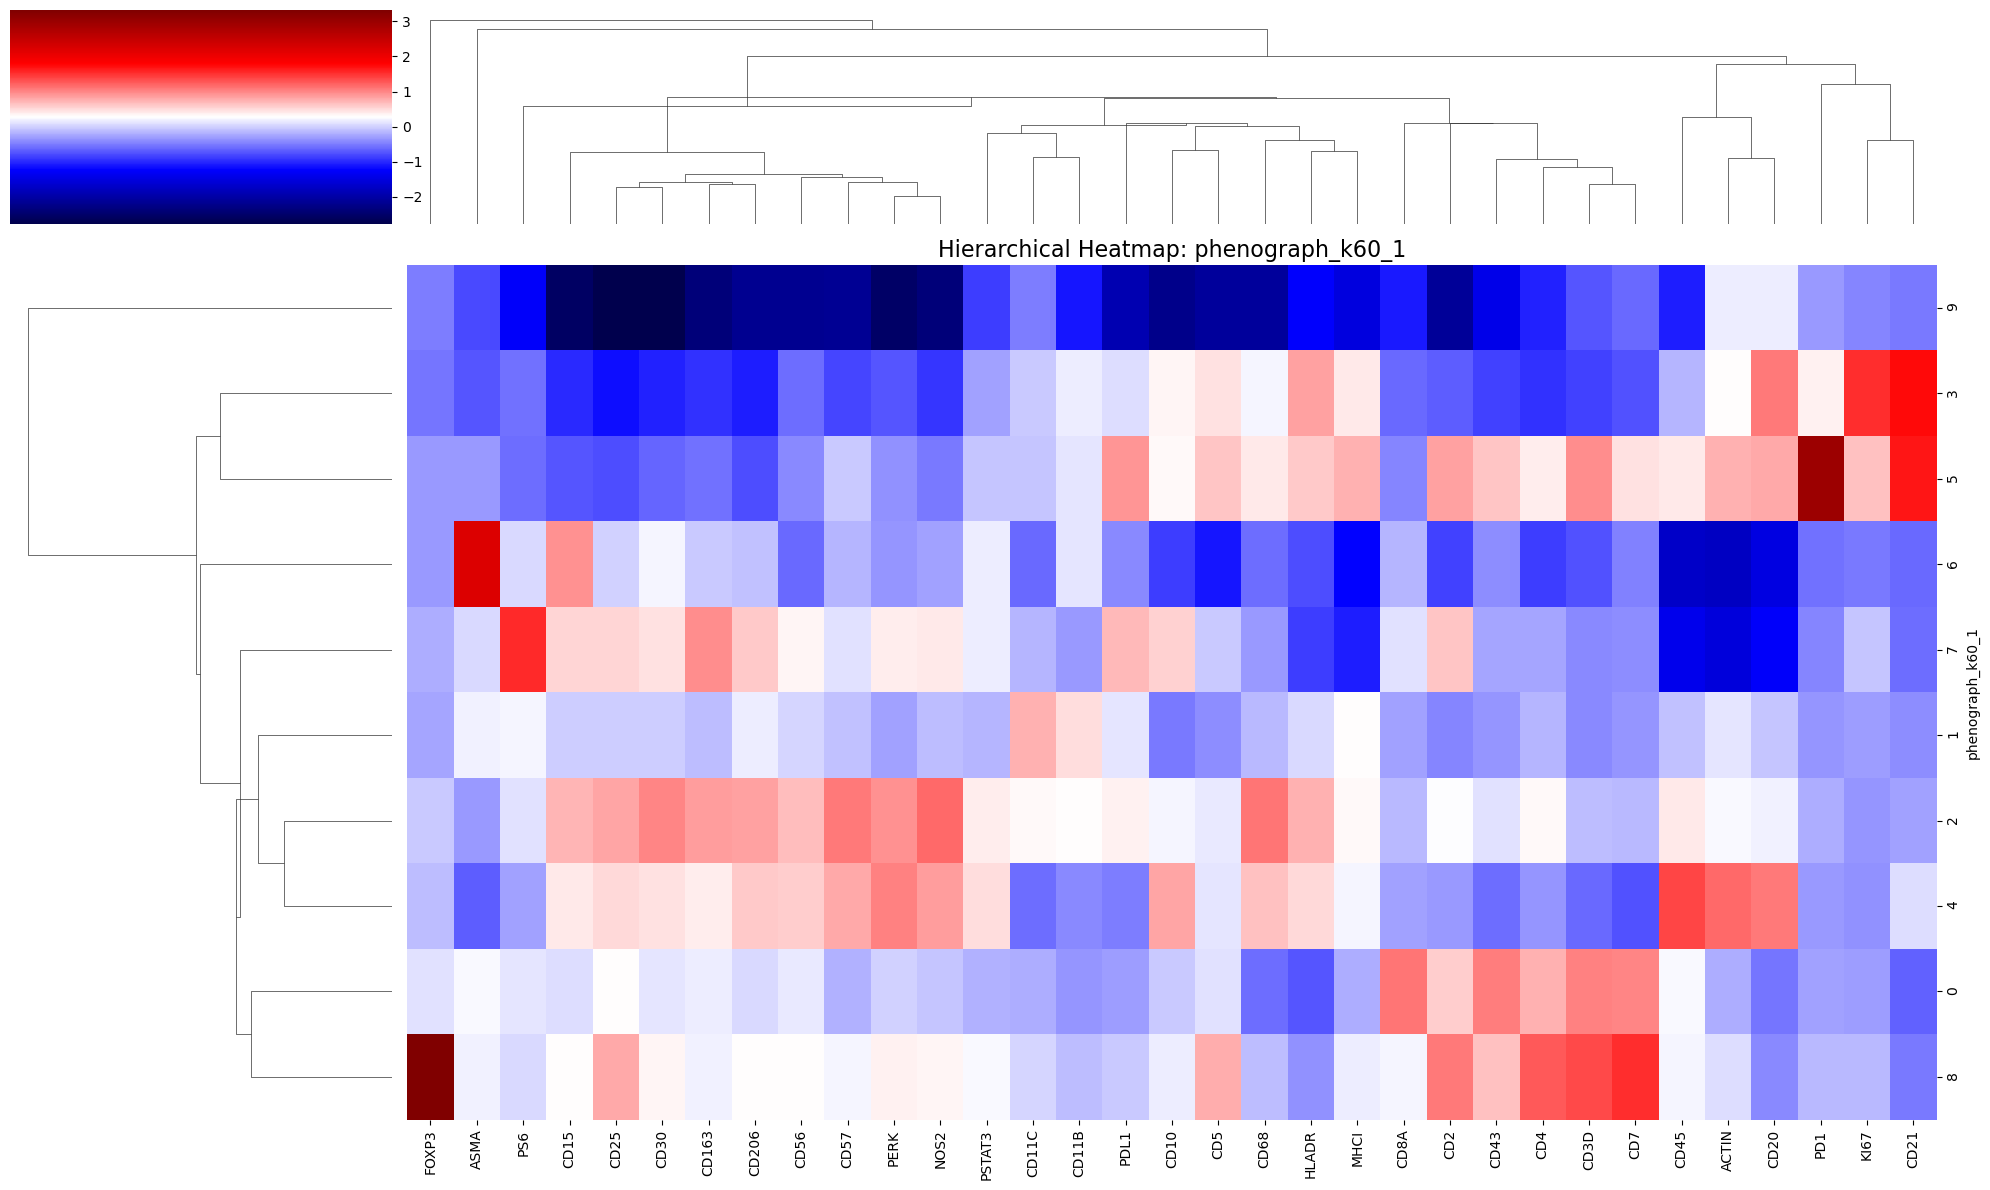

/Users/liuf9/Projects/SCSAWorkflow/src/spac/visualization.py:878: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = pd.concat([intensities, labels], axis=1).groupby(annotation)


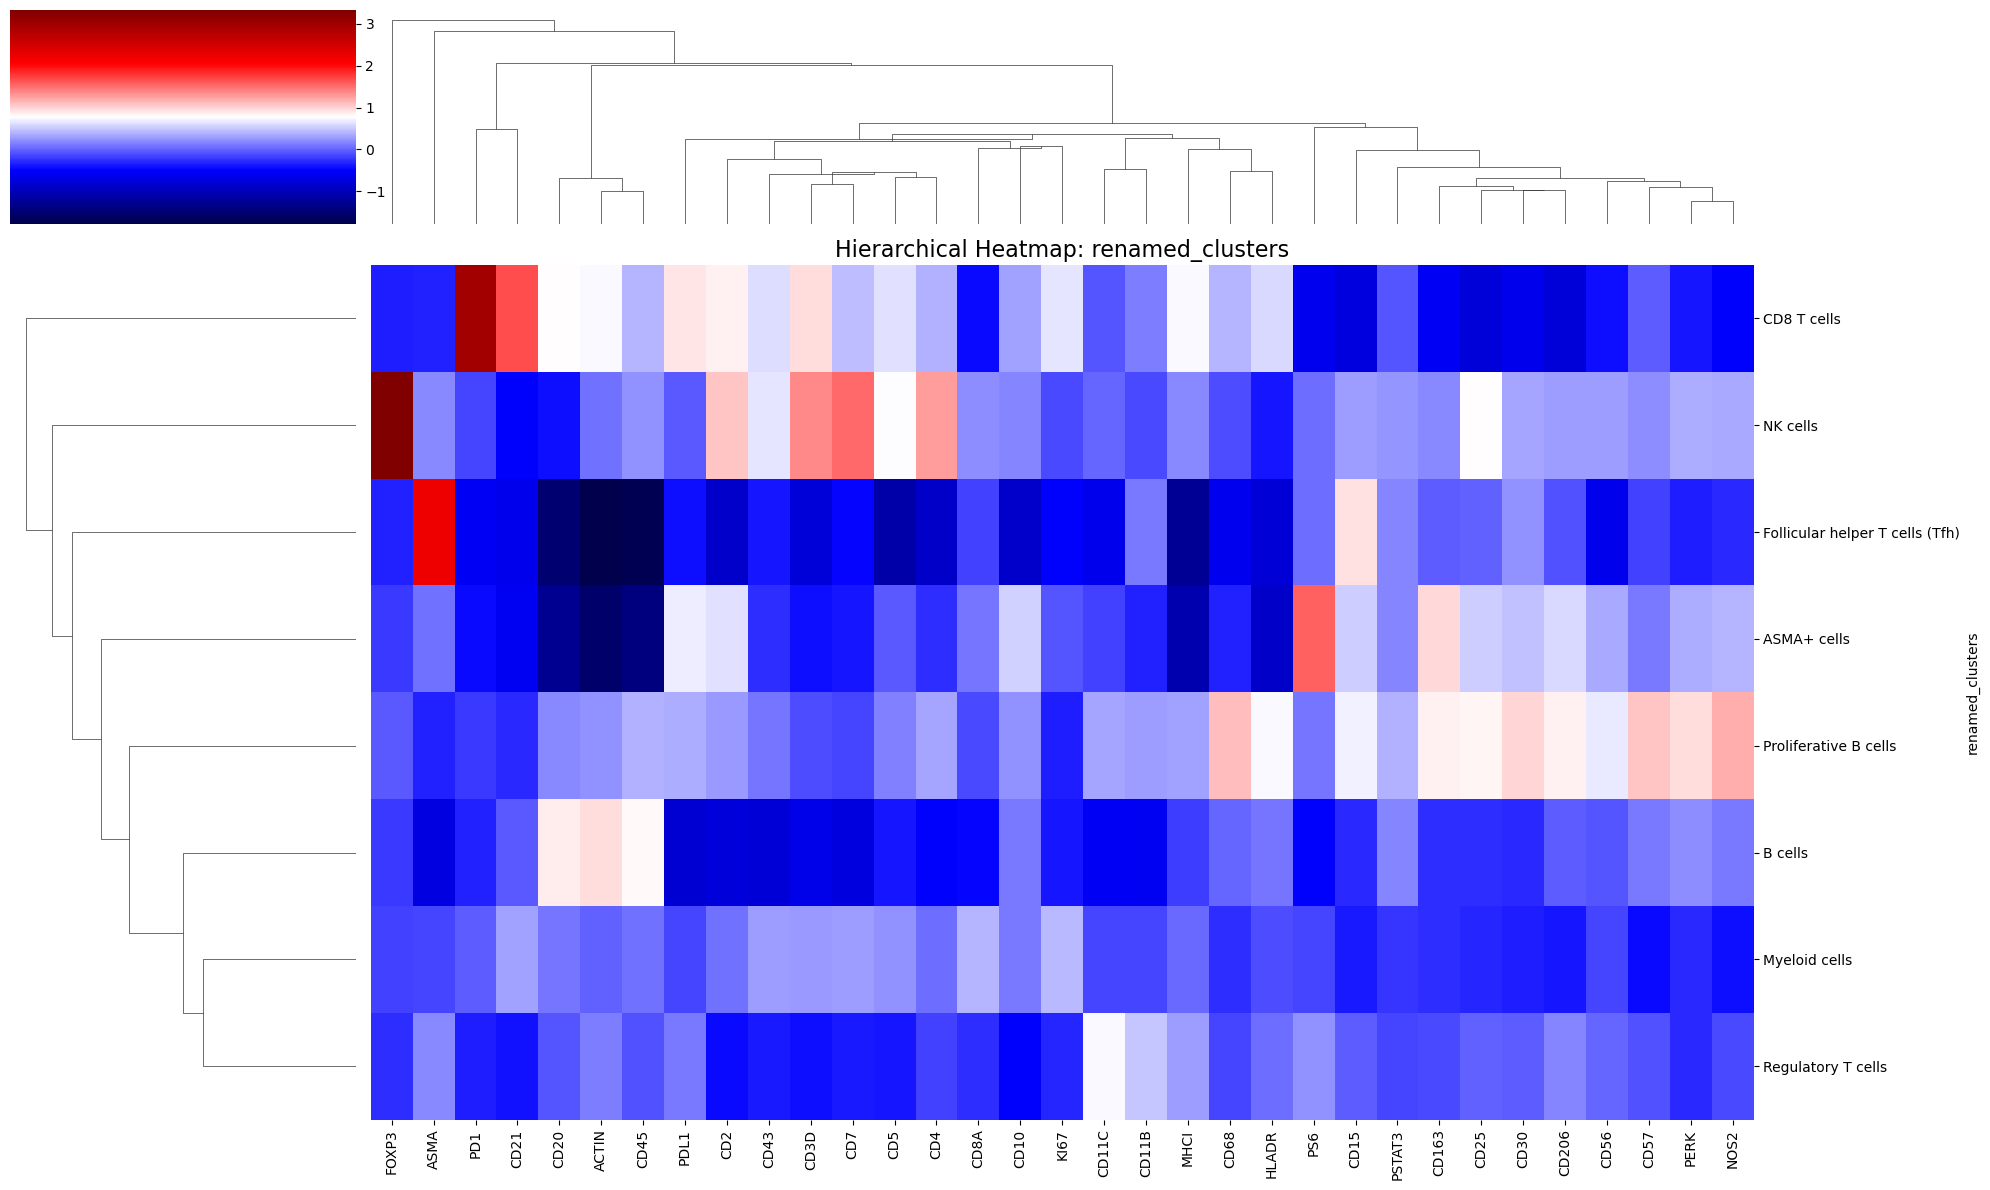

In [19]:
# Define selected annotations to plot (set to None to plot all annotations)
selected_annotations = ['phenograph_k60_1', 'renamed_clusters']  # Modify as needed

# Determine which annotations to plot
if selected_annotations is None:
    annotations_to_plot = adata.obs.columns.tolist()
else:
    annotations_to_plot = [ann for ann in selected_annotations if ann in adata.obs.columns]

fig_width = 20
fig_height = 12
fig_dpi = 300
layer_to_plot = norm_zscore_output_layer
features = None
standard_scale = None
z_score = None
cluster_feature = True
cluster_annotations = True
Figure_Title = "Hierarchical Heatmap"
font_size = 16
matrix_ratio = 0.1
swap_axes = False
rotate_label = False
r_h_axis_dengrogram =0.2
r_v_axis_dengrogram = 0.2
color_map='seismic'

# Loop through each selected annotation and create hierarchical heatmap
for i, annotation in enumerate(annotations_to_plot):
    _, clustergrid, _ = hierarchical_heatmap(
        adata, 
        annotation=annotation,
        features=features, 
        layer=layer_to_plot,
        cluster_feature=cluster_feature,
        cluster_annotations=cluster_annotations,
        standard_scale=standard_scale,
        z_score=z_score,
        swap_axes=swap_axes,
        rotate_label=rotate_label,
        figsize=(fig_width,fig_height),
        dendrogram_ratio=(r_h_axis_dengrogram,r_v_axis_dengrogram),
        cmap=color_map
    )

    clustergrid.ax_heatmap.set_title(f'{Figure_Title}: {annotation}', fontsize=font_size)
    clustergrid.height = fig_height*matrix_ratio
    clustergrid.width = fig_width*matrix_ratio

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

### Sankey Plot

2025-04-14 23:38:51,206 - INFO - Source: phenograph_k60_1
2025-04-14 23:38:51,207 - INFO - Target: renamed_clusters
2025-04-14 23:38:51,208 - INFO - Source and Target are the same
/Users/liuf9/Projects/SCSAWorkflow/src/spac/utils.py:532: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  relationships = adata.obs.groupby(
/Users/liuf9/Projects/SCSAWorkflow/src/spac/utils.py:540: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  relationships.groupby(source_annotation)['count'].transform('sum')
/Users/liuf9/Projects/SCSAWorkflow/src/spac/utils.py:548: FutureWarning: The default of observed=False is deprecated and will 

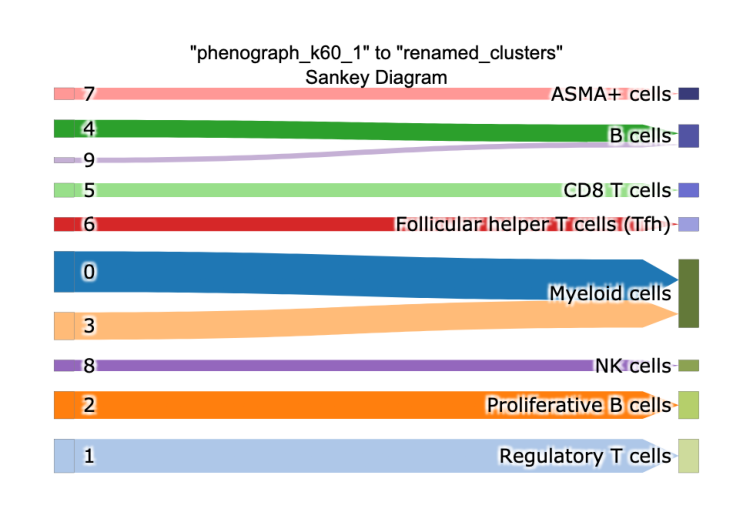

In [20]:
# ! pip install -U kaleido
# Set Up Figure Parameters
dpi = 300
width_num = 3   # desired width in inches
height_num = 2  # desired height in inches
# Calculate scale assuming 96 dpi is the default
scale = dpi / 96
# Convert inches into pixels based on the desired DPI.
width_in_pixels = width_num / scale * dpi
height_in_pixels = height_num / scale * dpi

# Define color maps and font size.
source_color_map = 'tab20'
target_color_map = 'tab20b'
sankey_font = 8

# Set the source and target annotations.
source_annotation = 'phenograph_k60_1'
target_annotation = 'renamed_clusters'

# Generate and Customize the Sankey Plot (Interactive)
fig = sankey_plot(
    adata=adata,
    source_annotation=source_annotation,
    target_annotation=target_annotation,
    source_color_map=source_color_map,
    target_color_map=target_color_map,
    sankey_font=sankey_font,
    prefix=False  # Disable automatic prefixing if needed.
)

# Adjust layout to the desired dimensions.
fig.update_layout(
    width=width_in_pixels,  
    height=height_in_pixels
)

# If you print or call fig.show() here, the interactive figure may open in a new window.
# print(fig)
# fig.show()

# Convert the Plotly Figure to a Static Image and Display Inline
# Specify a path for the static image file.
image_path = 'sankey_diagram.png'

# Use the 'kaleido' engine to export the Plotly figure as a PNG image.
pio.write_image(
    fig,
    image_path,
    width=width_in_pixels,  
    height=height_in_pixels,
    engine='kaleido',
    scale=scale
)

# Now load the generated image with matplotlib.
img = plt.imread(image_path)

# Create a Matplotlib figure and axis.
static_fig, ax = plt.subplots(1, 1, figsize=(width_num, height_num), dpi=dpi)
ax.imshow(img)
ax.axis('off')  # Remove axis lines/ticks for a cleaner display.
plt.show()

# Optionally, you can also call fig.show() to open the interactive version if desired.
# fig.show()

## Spatial Analysis

### Spatial Plot Analysis

... storing 'broad_cell_type' as categorical
... storing 'detailed_cell_type' as categorical
... storing 'manual_phenotype' as categorical


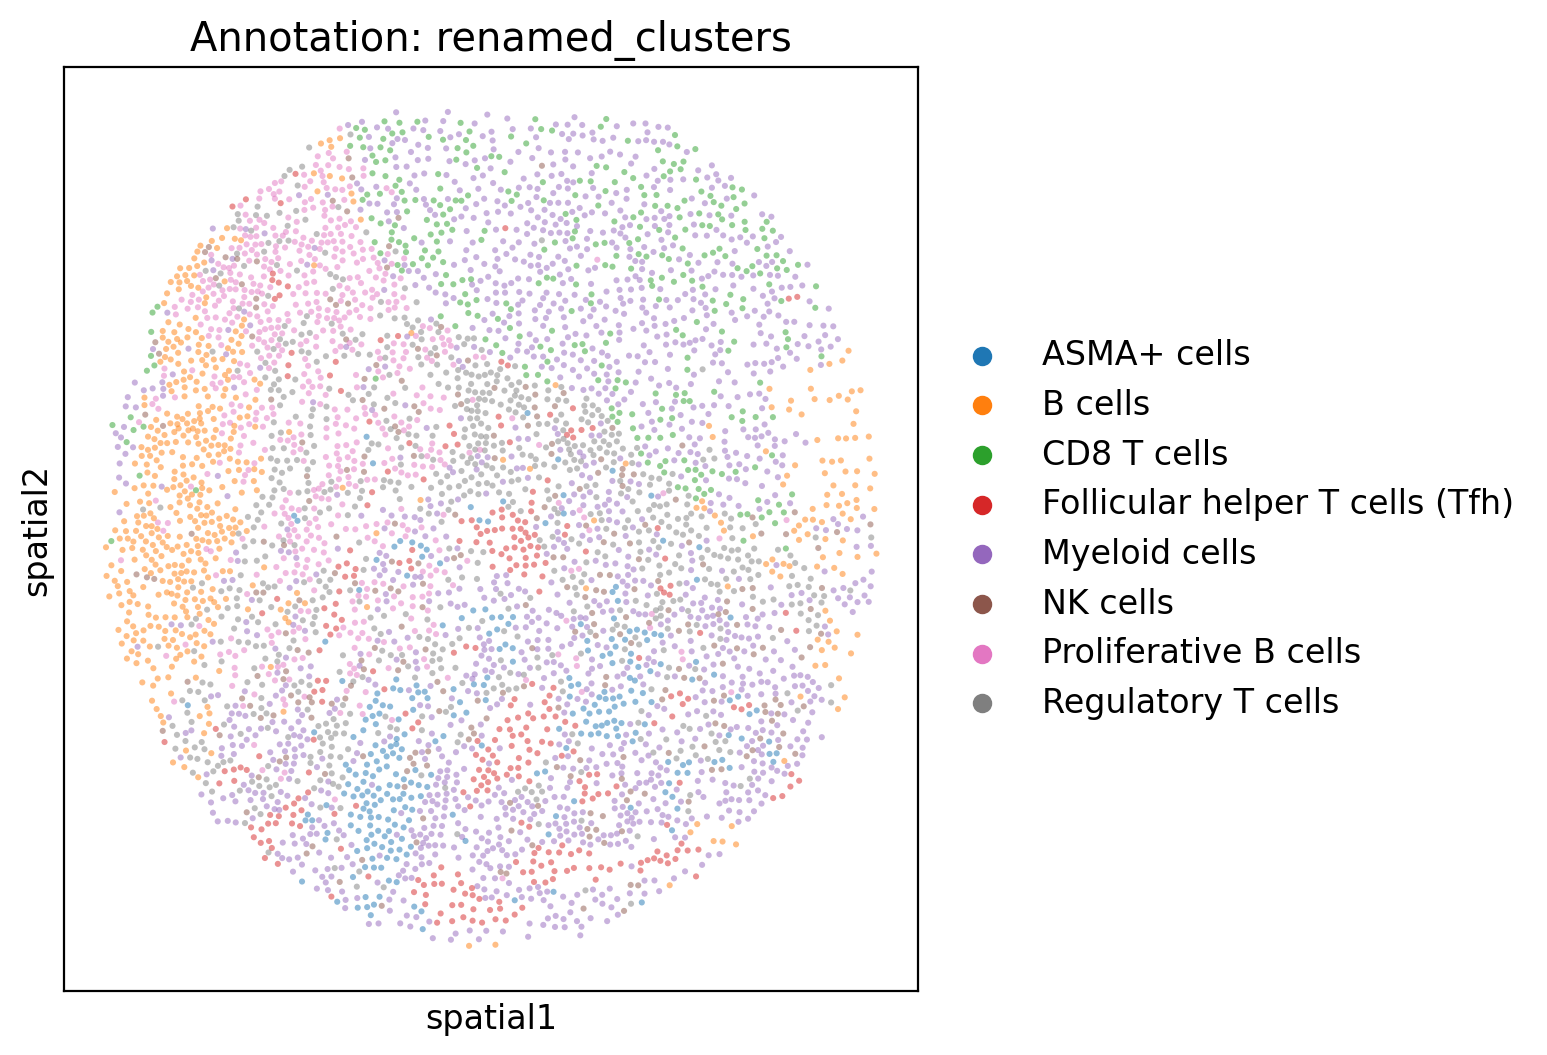

In [21]:
annotation = "renamed_clusters"
feature = None
layer = "arcsinh_z_scores"

alpha = 0.5
spot_size = 8
image_height = 6 
image_width = 12
dpi = 200
font_size = 12
vmin = -999
vmax = -999
color_by = "Annotation"

prefilled_spatial = partial(
    spatial_plot,
    spot_size=spot_size,
    alpha=alpha,
    vmin=vmin,
    vmax=vmax,
    annotation=annotation,
    feature=feature,
    layer=layer
)

plt.rcParams['font.size'] = font_size
fig, ax = plt.subplots(figsize=(image_width, image_height), dpi=dpi)

# Use the existing adata object from the previous computation
ax = prefilled_spatial(adata=adata, ax=ax)

# Set the title based on the "color_by" parameter
if color_by == "Annotation":
    title = f'Annotation: {annotation}'
else:
    title = f'Table: "{layer}" \nFeature: "{feature}"'

# If ax is a list/tuple of axes, set title on the first axis, otherwise directly set on ax.
try:
    ax[0].set_title(title)
except (TypeError, IndexError):
    ax.set_title(title)

plt.show()

### Nearest Neighbor Calculation and Visualization


In [22]:
# Nearest Neighbor Calculation
annotation = "renamed_clusters"
spatial_associated_table = "spatial"
imageid = None           # If multiple images exist, provide the column name; otherwise, "None"
label = "spatial_distance" # Key under which to store the distance DataFrame in adata.obsm

# Perform the nearest neighbor calculation.
calculate_nearest_neighbor(
    adata=adata,
    annotation=annotation,
    spatial_associated_table=spatial_associated_table,
    imageid=imageid,
    label=label
)

# Save the updated adata object for future use.
save_pickle(adata)

Running SCIMAP  2.1.3
Preparing data for spatial distance calculation...
Processing Image: dummy_image
Spatial distances stored in adata.obsm['spatial_distance']
Preview of the distance DataFrame:
    Myeloid cells  CD8 T cells  Proliferative B cells  Regulatory T cells  \
0      23.951263    14.393124              76.939216           66.463845   
1      13.418854    21.946570             128.137355          130.921068   
2      20.247170    32.127516             161.278346          179.462600   
3      13.340312    34.250638             189.037034          166.806641   
4      15.548248    24.043808             179.559171          165.763012   

      B cells    NK cells  Follicular helper T cells (Tfh)  ASMA+ cells  
0   80.954973   86.664061                       154.489135   426.731652  
1  145.389003  141.920128                       169.805128   407.928653  
2  195.348749   98.025538                       150.610770   394.408492  
3  308.352498   76.612886                       1

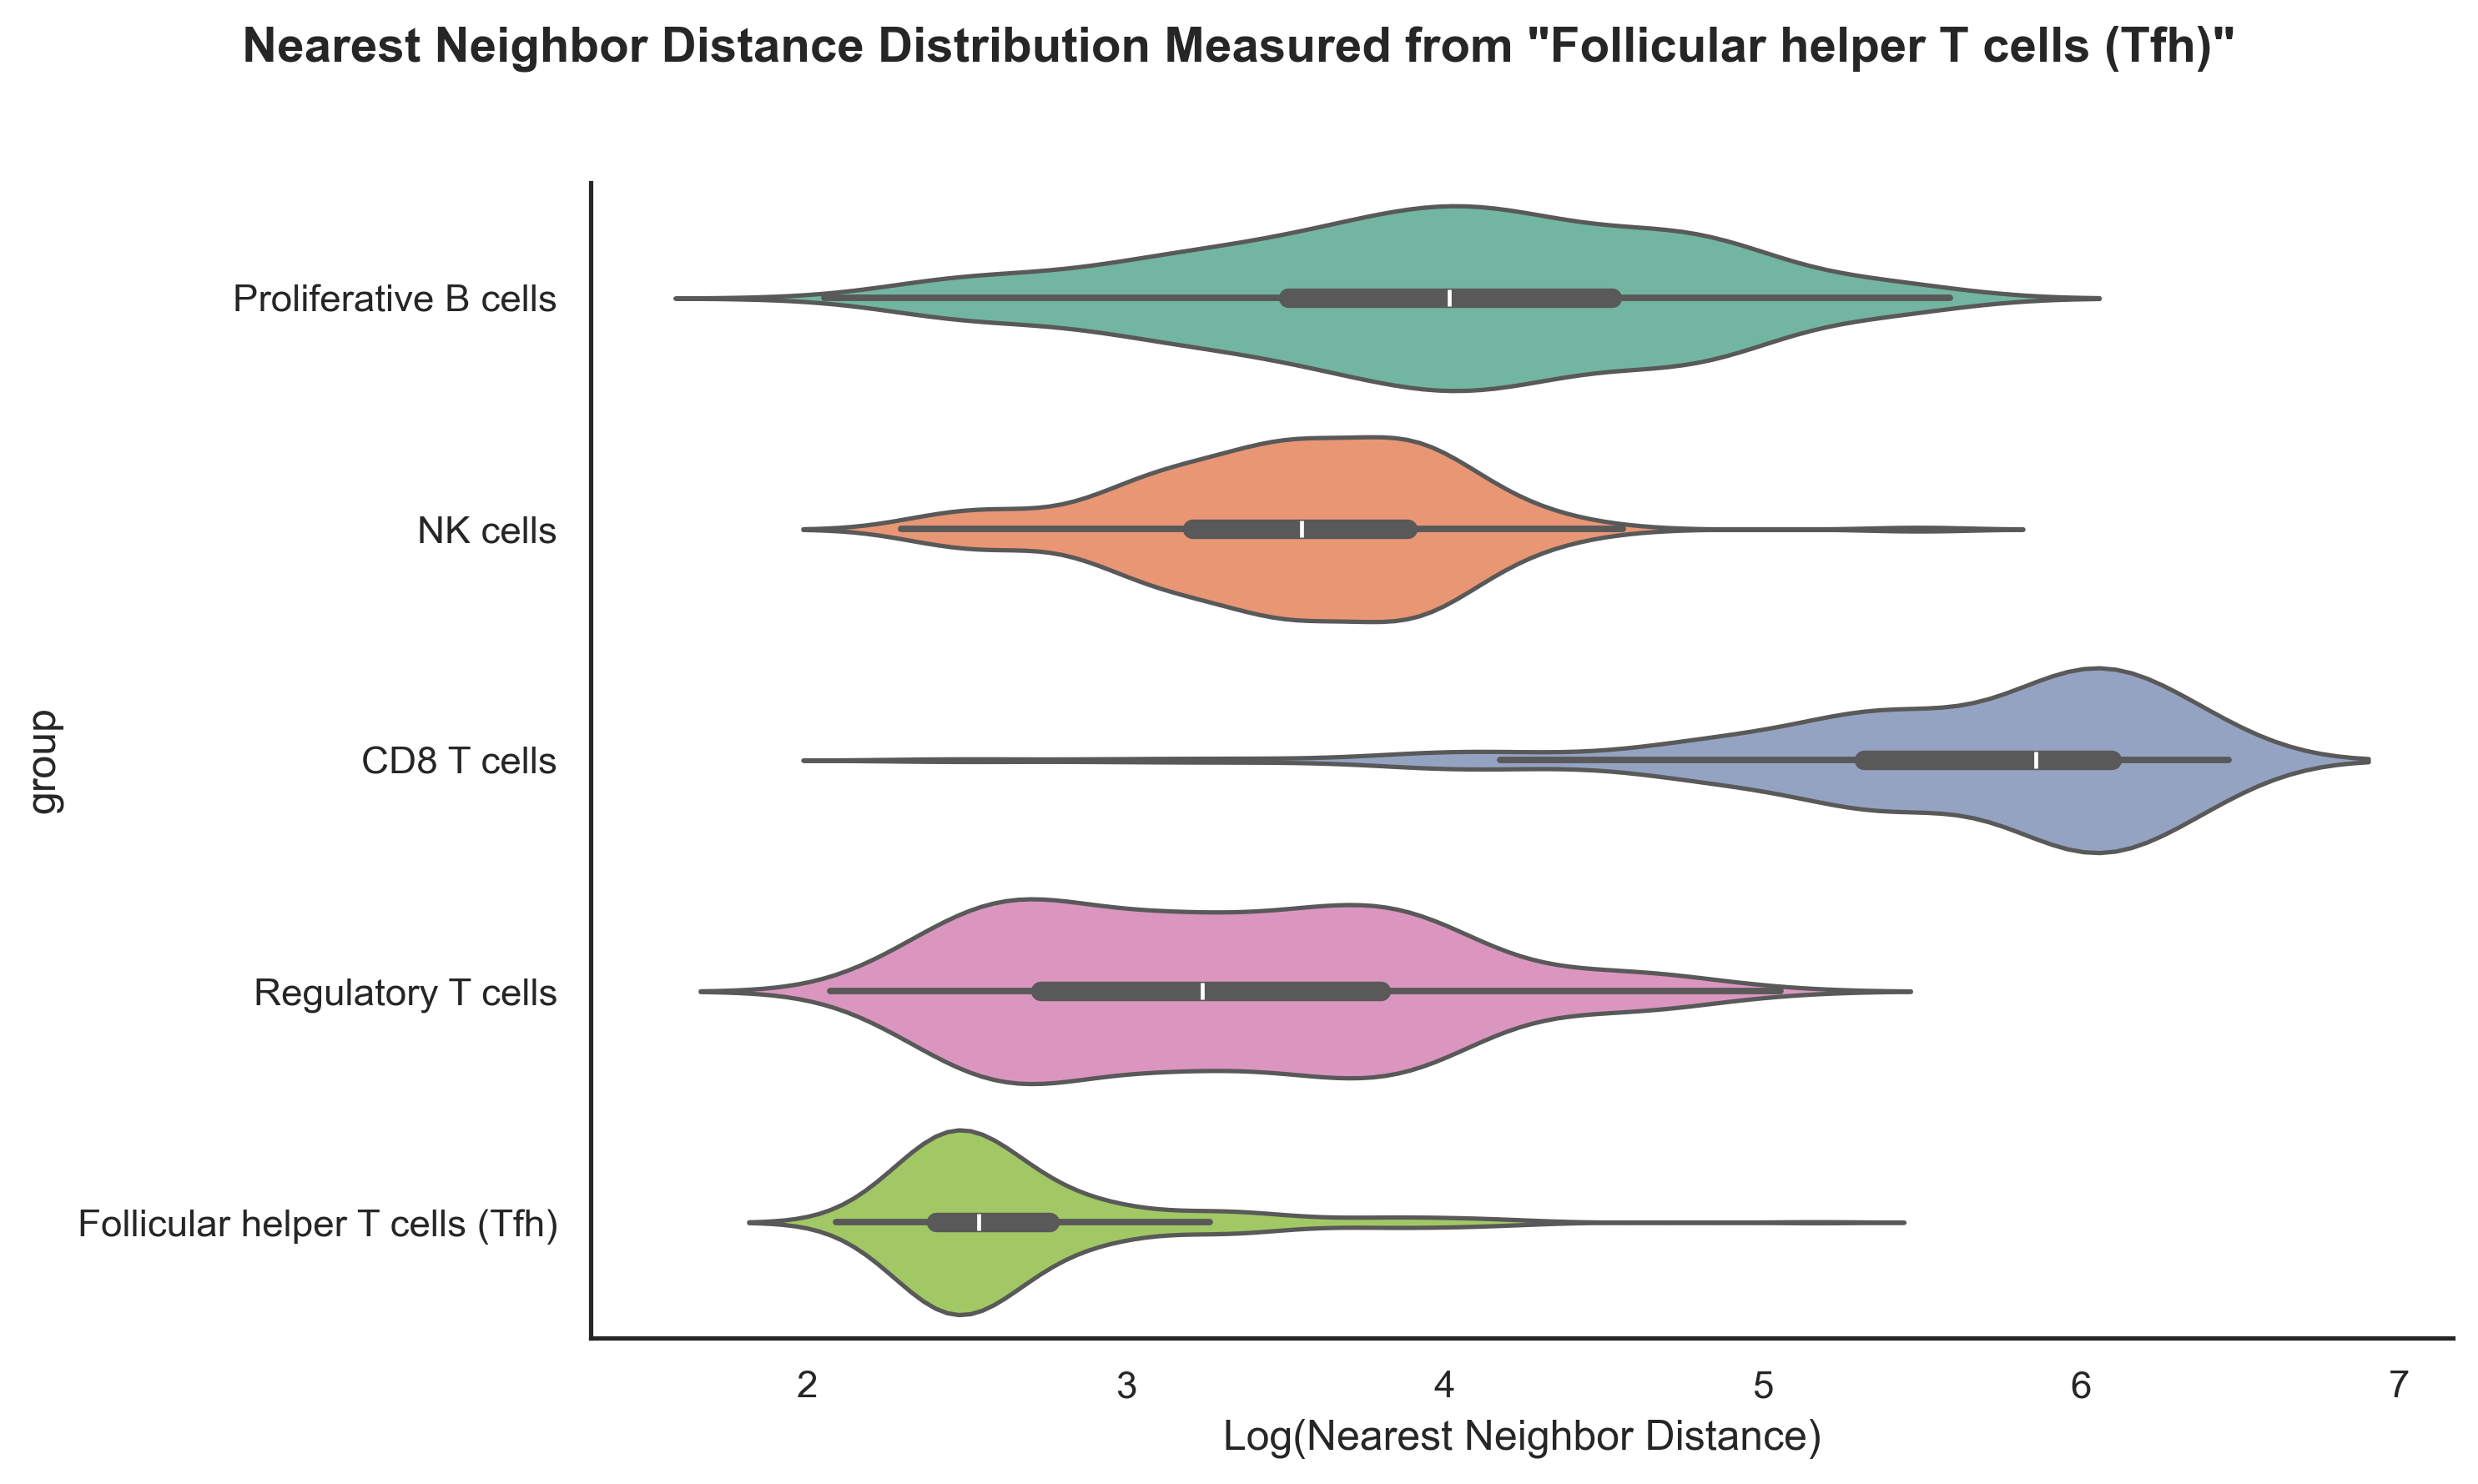

In [23]:
# Nearest Neighbor Visualization
# Define parameters for visualization.
annotation = "renamed_clusters"                 # Specify phenotypes from calculation node.
image_id = None                               # For multiple images, use a column name; otherwise "None".
method = "numeric"                              # Options: 'numeric' or 'distribution'.
plot_type = "violin"                             # e.g., 'box', 'violin', 'kde', 'hist', etc.
source_label = "Follicular helper T cells (Tfh)"# The phenotype from which distances are measured.
target_label = "Proliferative B cells, NK cells, CD8 T cells, Regulatory T cells, Follicular helper T cells (Tfh)"  
distance_label = "spatial_distance"             # Must match the key used in the NN calculation.
log_scale = True                               # Apply log1p transform if True.
facet_plot = False                              # True => display as subplots; otherwise, a single figure.
fig_width = 10
fig_height = 6
fig_dpi = 300
font_size = 10
fig_title = f'Nearest Neighbor Distance Distribution Measured from "{source_label}"'

# Process target_label to create a list (if not "All").
if target_label is not None:
    distance_to_processed = [x.strip() for x in target_label.split(",")]
else:
    distance_to_processed = None

# Configure Matplotlib font size.
plt.rcParams.update({'font.size': font_size})

# Define extra keyword arguments for the plot.
extra_kwargs = {
    "col_wrap": 2,
    "hue": "group",
    "palette": "Set2"    # Change palette if desired.
}

# If not facet_plot, remove facet-specific kwargs
if not facet_plot:
    extra_kwargs.pop("col_wrap", None)
# Visualize the nearest neighbor distances.
result_dict = visualize_nearest_neighbor(
    adata=adata,
    annotation=annotation,
    spatial_distance=distance_label,
    distance_from=source_label,
    distance_to=distance_to_processed,
    method=method,
    plot_type=plot_type,
    stratify_by=image_id,
    facet_plot=facet_plot,
    log=log_scale,
    **extra_kwargs
)

# Adjust figure properties (size, DPI, layout, title).
def _title_main(fig, title):
    """
    Adjusts figure size, DPI, layout and sets a bold, centered title.
    """
    fig.set_size_inches(fig_width, fig_height)
    fig.set_dpi(fig_dpi)
    # Adjust layout to make space at the top for the title.
    fig.tight_layout(rect=[0, 0, 1, 0.90])
    fig.suptitle(
        title,
        fontsize=font_size + 4,
        weight='bold',
        x=0.5,  # center horizontally
        horizontalalignment='center'
    )

# If multiple figures are returned (facet_plot=True), apply _title_main to each.
if isinstance(result_dict["fig"], (list, tuple)):
    for fig in result_dict["fig"]:
        _title_main(fig, fig_title)
else:
    _title_main(result_dict["fig"], fig_title)

plt.show()

### Ripley-L Calculation and Visualization

In [24]:
# Ripley L Calculation
# Convert radii to numeric values (if the function expects numbers)
radii = [0, 50, 100, 150, 200, 250, 300]

annotation = "renamed_clusters"
# Provide the phenotypes to analyze 
phenotypes = ["B cells", "Regulatory T cells"]

regions = None
n_simulations = 100
area = None
seed = 42
spatial_key = "spatial"

# Call ripley_l to compute Ripley's L function.
ripley_l(
    adata,
    annotation=annotation,
    phenotypes=phenotypes,
    distances=radii,
    regions=regions,
    n_simulations=n_simulations,
    area=area,
    seed=seed,
    spatial_key=spatial_key
)
save_pickle(adata)

Processing region:"all".
Cells in region:"4825"
Saved processed object to Lymph_Node_Tissue.pickle


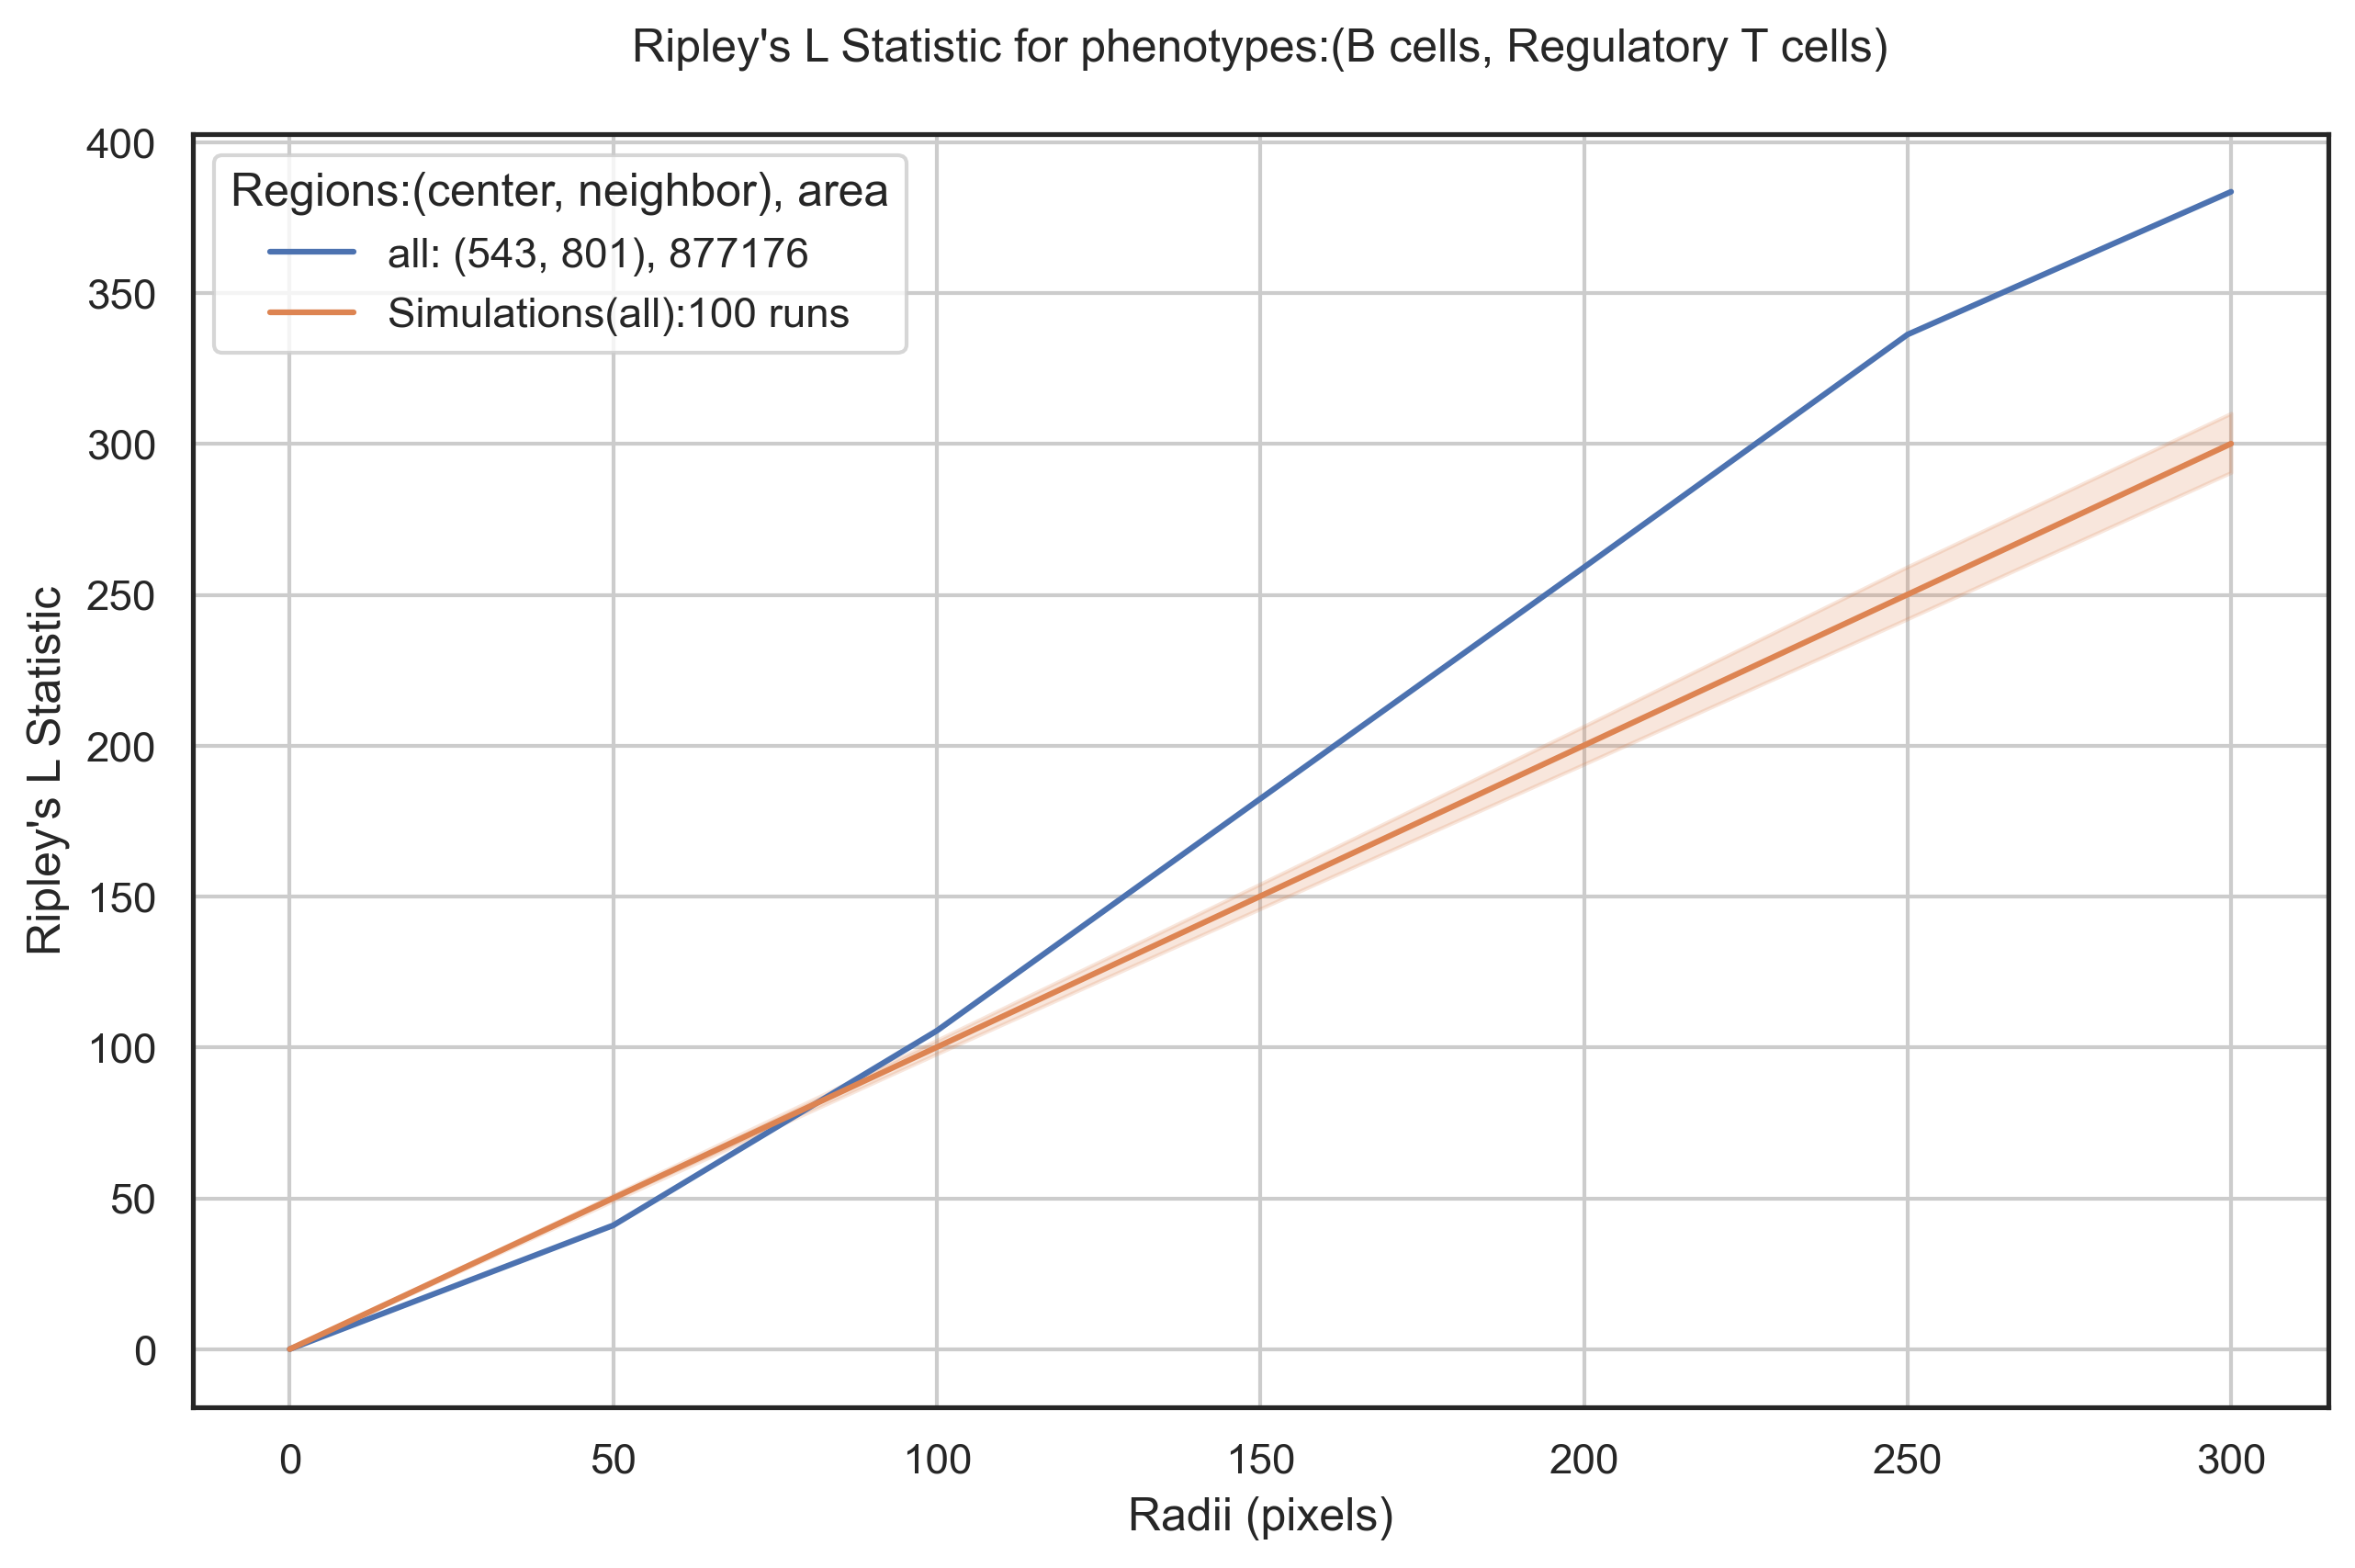

In [25]:
# Ripley L Plotting
# Define the center phenotype and the neighbor phenotype 
center_phenotype = "B cells"
neighbor_phenotype = "Regulatory T cells"

plot_specific_regions = False
regions_labels = []  # If you have specific region labels, list them here.
plot_simulations = True

# If plot_specific_regions is True and no region labels are provided, then raise an error.
if plot_specific_regions:
    if len(regions_labels) == 0:
        raise ValueError('Please identify at least one region in the "Regions Label(s)" parameter.')
else:
    regions_labels = None

# Plot the Ripley L results.
fig, plots_df = plot_ripley_l(
    adata,
    phenotypes=(center_phenotype, neighbor_phenotype),
    regions=regions_labels,
    sims=plot_simulations,
    return_df=True
)

# Optionally, adjust figure properties (if needed).
fig.set_size_inches(10, 6)
fig.set_dpi(300)

plt.show()

### Neighborhood Enrichment

100%|██████████| 1000/1000 [00:08<00:00, 122.96/s]
/Users/liuf9/opt/anaconda3/envs/spac-3913/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning:

The dtype argument is deprecated and will be removed in late 2024.

/Users/liuf9/opt/anaconda3/envs/spac-3913/lib/python3.9/site-packages/squidpy/pl/_utils.py:555: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



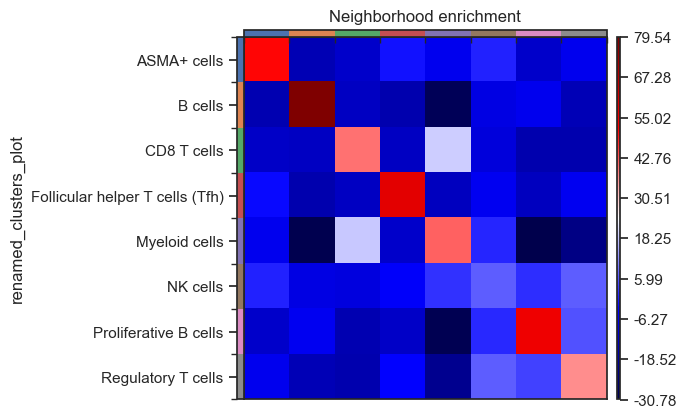

In [26]:
annotation = "renamed_clusters"
analysis_method = "Neighborhood Enrichment"
stratify_by = None
seed = None
coord_type = None
n_rings = 1
n_neighs = 6
radius = None
image_width = 15
image_height = 12
dpi = 200
font_size = 12
color_bar_range = "Automatic"

# Determine colormap and vmin/vmax based on the color_bar_range
cmap = "seismic"
if color_bar_range != "Automatic":
    # If you provide a numeric value for color_bar_range, use it to calculate limits.
    vmin = -abs(color_bar_range)
    vmax = abs(color_bar_range)
else:
    # Let the spatial_interaction function decide the limits automatically.
    vmin = None
    vmax = None

# Set the global font size for Matplotlib
plt.rcParams['font.size'] = font_size

# --------------------------------------------------
# Call the spatial_interaction function using the current adata
# --------------------------------------------------
spatial_interaction(
    adata=adata,
    annotation=annotation,
    analysis_method=analysis_method,
    stratify_by=stratify_by,
    return_matrix=True,
    seed=seed,
    coord_type=coord_type,
    n_rings=n_rings,
    n_neighs=n_neighs,
    radius=radius,
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    figsize=(image_width, image_height),
    dpi=dpi
)
plt.show()